## Requirements
TensorFlow 2.4 or higher TensorFlow Addons can be installed using :
pip install -U tensorflow-addons

# Setup

In [1]:
pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


##Prepare the data

## Prepare the Data

In [3]:

# Define the number of classes in the dataset
num_classes = 100

# Define the input shape for the dataset, which is a 32x32 image with 3 color channels (RGB)
input_shape = (32, 32, 3)

# Load the CIFAR-100 dataset from Keras datasets, splitting it into training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()


In [4]:
# Display the shape of the training data (x_train and y_train)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")

# x_train shape: (number of training samples, height, width, color channels)

# Display the shape of the testing data (x_test and y_test)

print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Declaring Hyperparameters

In [5]:
# Learning rate controls the step size during model training
learning_rate = 0.001

# Weight decay is a regularization term to prevent overfitting
weight_decay = 0.0001

# Batch size defines the number of samples processed in each iteration of training
batch_size = 256

# Number of training epochs specifies how many times the entire dataset is passed through during training
num_epochs = 100

# Image size represents the dimensions to which input images will be resized
image_size = 72  # We'll resize input images to this size

# Patch size determines the size of the patches extracted from input images
patch_size = 6   # Size of the patches to be extracted from the input images

# Number of patches is calculated based on image size and patch size, representing the spatial information
num_patches = (image_size // patch_size) ** 2

# Projection dimension specifies the dimensionality of the feature vectors used within the transformer
projection_dim = 64

# Number of attention heads controls the multi-head self-attention mechanism
num_heads = 4

# Transformer units define the size of the transformer layers in the model
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers

# Transformer layers specify how many transformer blocks are stacked in the architecture
transformer_layers = 8

# MLP head units define the size of the dense layers in the final classification part of the model
mlp_head_units = [2048, 1024]


## Creating Data Augmentation Pipeline

In [6]:
# Use data augmentation

# Create a data augmentation pipeline using a Keras Sequential model
data_augmentation = keras.Sequential(
    [
        # Normalize the input data, typically by subtracting the mean and dividing by the standard deviation
        layers.Normalization(),

        # Resize input images to a consistent size (image_size x image_size)
        layers.Resizing(image_size, image_size),

        # Randomly flip images horizontally (e.g., for left-right transformations)
        layers.RandomFlip("horizontal"),

        # Randomly rotate images by a small factor (factor=0.02) for additional variability
        layers.RandomRotation(factor=0.02),

        # Apply random zooming to images (both height and width) for further diversity
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",  # Name for the data augmentation pipeline
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implementing multilayer perceptron (MLP)

In [7]:
# Define an MLP (Multilayer Perceptron) architecture as a function
def mlp(x, hidden_units, dropout_rate):
    """
    Args:
        x (tf.Tensor): Input tensor.
        hidden_units (list): List of integers specifying the number of units in each hidden layer.
        dropout_rate (float): Dropout rate to apply after each hidden layer.
    
    Returns:
        x (tf.Tensor): Output tensor after passing through the MLP layers.
    """

    # Iterate through the hidden_units list to create hidden layers
    for units in hidden_units:
        # Add a dense (fully connected) layer with the specified number of units and the gelu activation function
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        
        # Apply dropout regularization to reduce overfitting
        x = layers.Dropout(dropout_rate)(x)

    # Return the output tensor after passing through all hidden layers
    return x


## Explanation of 👆

def mlp(x, hidden_units, dropout_rate): This function is defined to create an MLP (Multilayer Perceptron) architecture that takes an input tensor x, a list of hidden_units specifying the number of units in each hidden layer, and a dropout_rate to apply after each hidden layer.

for units in hidden_units:: This loop iterates through the list of hidden_units to create multiple hidden layers in the MLP.

x = layers.Dense(units, activation=tf.nn.gelu)(x): Inside the loop, a dense (fully connected) layer is added with the specified number of units in the hidden layer. The GELU activation function (Gaussian Error Linear Unit) is used as the activation function for this layer.

x = layers.Dropout(dropout_rate)(x): After each hidden layer, dropout regularization is applied with the specified dropout_rate. Dropout helps prevent overfitting by randomly dropping a fraction of the units during training.
Finally, the function returns the output tensor x after passing it through all the hidden layers.

This function allows you to easily define and customize an MLP architecture with varying numbers of hidden layers and units, as well as dropout regularization, for different machine learning tasks.

## Implementing patch creation as a layer

In [8]:
# Define a custom layer called "Patches" for extracting patches from input images

class Patches(layers.Layer):
    def __init__(self, patch_size):
        """
        Args:
            patch_size (int): The size of the square patches to be extracted from input images.
        """
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        """
        Args:
            images (tf.Tensor): Input images from which patches will be extracted.
        
        Returns:
            patches (tf.Tensor): Extracted patches reshaped into a 3D tensor.
        """
        batch_size = tf.shape(images)[0]
        
        # Use tf.image.extract_patches to extract patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        # Determine the dimensions of the extracted patches
        patch_dims = patches.shape[-1]
        
        # Reshape the patches into a 3D tensor, where the first dimension is the batch size
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        # Return the extracted patches as a 3D tensor
        return patches


## Display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


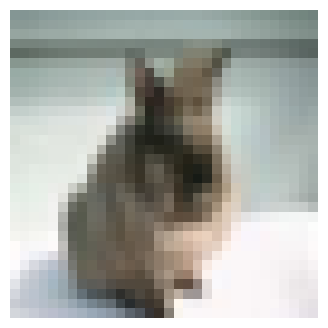

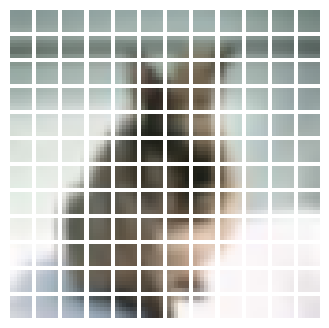

In [9]:

import matplotlib.pyplot as plt

# Create a figure for displaying the original image

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]  # Select a random image from the training data
plt.imshow(image.astype("uint8"))  # Display the image
plt.axis("off")

# Resize the image to the specified image size
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

# Extract patches from the resized image using the custom Patches layer
patches = Patches(patch_size)(resized_image)

# Print information about the patches and their sizes
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# Create a figure for displaying the extracted patches
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
    

## Implement the patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [17]:

# Define a custom layer called "PatchEncoder" for encoding patches
@keras.saving.register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        """
        Args:
            num_patches (int): The number of patches extracted from an image.
            projection_dim (int): The dimensionality of the projected vector.
        """
        super().__init__()
        
        # Number of patches and projection dimension are initialized as attributes
        self.num_patches = num_patches
        
        # Define a dense layer for linear transformation (projection) of each patch
        self.projection = layers.Dense(units=projection_dim)
        
        # Define an embedding layer for adding learnable position embeddings
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        """
        Args:
            patch (tf.Tensor): A patch (vector) extracted from an image.
        
        Returns:
            encoded (tf.Tensor): The encoded representation of the input patch.
        """
        # Generate positional embeddings based on the number of patches
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        
        # Apply linear transformation (projection) to the input patch
        projected_patch = self.projection(patch)
        
        # Add learnable position embeddings to the projected vector
        encoded = projected_patch + self.position_embedding(positions)
        
        # Return the encoded representation of the input patch
        return encoded

## Build the ViT model
The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [18]:
def create_vit_classifier():
    # Define the input layer with the specified input shape (e.g., image dimensions)
    inputs = layers.Input(shape=input_shape)
    
    # Augment the input data using the data augmentation pipeline defined earlier
    augmented = data_augmentation(inputs)
    
    # Create patches from the augmented data using the custom Patches layer
    patches = Patches(patch_size)(augmented)
    
    # Encode the patches using the custom PatchEncoder layer
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block for feature extraction.
    for _ in range(transformer_layers):
        # Layer normalization 1 is applied to the encoded patches.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Create a multi-head attention layer to capture dependencies between patches.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection 1 adds the attention output to the encoded patches.
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2 is applied to the combined output.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP (Multi-Layer Perceptron) processes the output to capture complex features.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        # Skip connection 2 adds the MLP output to the previous output.
        encoded_patches = layers.Add()([x3, x2])

    # Create a representation tensor by applying layer normalization and flattening.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    
    # Apply dropout regularization to the representation tensor for improved generalization.
    representation = layers.Dropout(0.5)(representation)
    
    # Add another MLP to process the representation and extract high-level features.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    # Classify the extracted features into the specified number of classes.
    logits = layers.Dense(num_classes)(features)
    
    # Create the Keras model with the defined inputs and outputs.
    model = keras.Model(inputs=inputs, outputs=logits)
    
    return model

## Explanation of above code 👆
The function starts by defining the input layer with the specified input_shape.
The input data is augmented using the data augmentation pipeline defined earlier to increase the diversity of the training data.

Patches are created from the augmented data using the custom Patches layer.

The patches are encoded using the custom PatchEncoder layer, which adds positional embeddings to each patch.

A stack of Transformer blocks is applied to the encoded patches to extract hierarchical features. This includes multi-head self-attention and MLP layers.

The output of the Transformer blocks is normalized, flattened, and subjected to dropout regularization for improved generalization.

Another MLP is applied to the representation to further capture high-level features.

Finally, the extracted features are classified into the specified number of classes using a dense layer, and the Keras model is created with the defined inputs and outputs.

## Compile, train, and evaluate the model

In [19]:
def run_experiment(model):
    # Define the optimizer using AdamW with specified learning rate and weight decay
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile the model with loss and evaluation metrics
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Define a checkpoint to save the best model weights during training
    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Train the model and store training history
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,  # Use 10% of the training data as validation
        callbacks=[checkpoint_callback],  # Save the best model during training
    )

    # Load the best model weights
    model.load_weights(checkpoint_filepath)

    # Evaluate the model on the test data
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)

    # Print test accuracy and top-5 accuracy
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

# Create a Vision Transformer (ViT) classifier model
vit_classifier = create_vit_classifier()


In [14]:
# Run an experiment to train and evaluate the ViT model
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 902s 5s/step - loss: 4.4842 - accuracy: 0.0444 - top-5-accuracy: 0.1572 - val_loss: 3.9307 - val_accuracy: 0.1004 - val_top-5-accuracy: 0.3062
Epoch 2/100
176/176 [==============================] - 838s 5s/step - loss: 3.9633 - accuracy: 0.0910 - top-5-accuracy: 0.2850 - val_loss: 3.6200 - val_accuracy: 0.1568 - val_top-5-accuracy: 0.3958
Epoch 3/100
176/176 [==============================] - 861s 5s/step - loss: 3.7021 - accuracy: 0.1310 - top-5-accuracy: 0.3647 - val_loss: 3.3343 - val_accuracy: 0.1970 - val_top-5-accuracy: 0.4772
Epoch 4/100
176/176 [==============================] - 885s 5s/step - loss: 3.5056 - accuracy: 0.1620 - top-5-accuracy: 0.4196 - val_loss: 3.1996 - val_accuracy: 0.2232 - val_top-5-accuracy: 0.5106
Epoch 5/100
176/176 [==============================] - 889s 5s/step - loss: 3.3591 - accuracy: 0.1868 - top-5-accuracy: 0.4612 - val_loss: 3.0827 - val_accuracy: 0.2484 - val_top-5-accuracy: 0.5378
Epoch 6/10

176/176 [==============================] - 875s 5s/step - loss: 0.8638 - accuracy: 0.7416 - top-5-accuracy: 0.9522 - val_loss: 1.9068 - val_accuracy: 0.5406 - val_top-5-accuracy: 0.8080
Epoch 84/100
176/176 [==============================] - 889s 5s/step - loss: 0.8320 - accuracy: 0.7507 - top-5-accuracy: 0.9552 - val_loss: 1.8992 - val_accuracy: 0.5388 - val_top-5-accuracy: 0.8072
Epoch 85/100
176/176 [==============================] - 883s 5s/step - loss: 0.8398 - accuracy: 0.7492 - top-5-accuracy: 0.9550 - val_loss: 1.9402 - val_accuracy: 0.5448 - val_top-5-accuracy: 0.8178
Epoch 86/100
176/176 [==============================] - 888s 5s/step - loss: 0.8468 - accuracy: 0.7478 - top-5-accuracy: 0.9548 - val_loss: 1.8743 - val_accuracy: 0.5462 - val_top-5-accuracy: 0.8168
Epoch 87/100
176/176 [==============================] - 885s 5s/step - loss: 0.8218 - accuracy: 0.7524 - top-5-accuracy: 0.9564 - val_loss: 1.9064 - val_accuracy: 0.5490 - val_top-5-accuracy: 0.8156
Epoch 88/100
176/1

In [14]:
# Save the entire ViT-based image classifier model to a file with the '.keras' extension

vit_classifier.save('vit_classifier.keras')

''' 
To Load the saved ViT-based image classifier model:

loaded_model = keras.models.load_model('vit_classifier.keras')

'''

" \nTo Load the saved ViT-based image classifier model:\n\nloaded_model = keras.models.load_model('vit_classifier.keras')\n\n"